In [1]:
#@markdown # Run to install dependencies and mount to google drive
# Step 1: Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Step 1: Install Required Packages

!pip install --upgrade pip
!pip install cellpose
!pip install scikit-image
!pip install pandas

# Step 2: Import Necessary Libraries

import os
import numpy as np
from cellpose import models
from skimage.io import imread, imsave
from skimage.measure import regionprops_table, label, regionprops
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 41.2 MB/s eta 0:00:00


In [2]:
#@markdown # Define the input and output directories
#@markdown ## Directory containing extracted tiff files files
input_dir = '/content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/tifs'  #@param {type:"string"}
#@markdown ## Directory to save label images
output_dir = '/content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels'#@param {type:"string"}
#@markdown ## Directory to save CSV files
csv_output_dir = '/content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/results_csv' #@param {type:"string"}

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(csv_output_dir, exist_ok=True)

# Step 3: Initialize the Cellpose Model

# Initialize the Cellpose model with 'cyto3'
model = models.Cellpose(gpu=False, model_type='cyto3')

# Key: base_name before '.sld'
# Value: list of DataFrames
data_dict = {}

100%|██████████| 25.3M/25.3M [00:00<00:00, 30.9MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

# Run to process the data

In [ ]:
# Step 4: Process TIFF Files

# Loop over each TIFF file in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.tif') or file_name.endswith('.tiff'):
        tiff_path = os.path.join(input_dir, file_name)
        img = imread(tiff_path)

        # Ensure the image has three channels
        if img.ndim < 3 or img.shape[-1] != 3:
            print(f"Skipping {file_name} as it does not have 3 channels.")
            continue

        # Extract channels 1 and 2 for Cellpose segmentation
        nuclei_channel = img[:, :, 0]
        cytoplasm_channel = img[:, :, 1]
        img_for_cellpose = np.stack([nuclei_channel, cytoplasm_channel], axis=-1)

        # Prepare the channels parameter for Cellpose
        channels = [0, 1]

        # Apply Cellpose segmentation
        masks, flows, styles, diams = model.eval(
            img_for_cellpose,
            diameter=95,
            channels=channels
        )

        # Step 4.1: Remove labels with area below 3000 pixels

        # Get properties of labeled regions
        props = regionprops(masks)

        # Create a list of labels to remove (areas less than 3000 pixels)
        labels_to_remove = [prop.label for prop in props if prop.area < 3000]

        # Remove small labels from the mask
        for label_to_remove in labels_to_remove:
            masks[masks == label_to_remove] = 0

        # Re-label the mask to ensure labels are consecutive integers
        masks = label(masks)

        # Save the filtered label image
        label_image_name = f"{os.path.splitext(file_name)[0]}_label.tif"
        label_image_path = os.path.join(output_dir, label_image_name)
        imsave(label_image_path, masks.astype(np.uint16))

        print(f"Processed and saved label image for {file_name}")

<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/As_Ctrl_n1.sld - Capture 1 - Position 2.Project Sum Z series_4_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for As_Ctrl_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif


<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/As_Ctrl_n1.sld - Capture 1 - Position 3.Project Sum Z series_6_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for As_Ctrl_n1.sld - Capture 1 - Position 3.Project Sum Z series_6.tif


<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/As_siCD441_n1.sld - Capture 1 - Position 1.Project Sum Z series_2_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for As_siCD441_n1.sld - Capture 1 - Position 1.Project Sum Z series_2.tif


<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/As_siCD441_n1.sld - Capture 1 - Position 2.Project Sum Z series_4_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for As_siCD441_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif


<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/Mia_siCD442_n1.sld - Capture 1 - Position 1.Project Sum Z series_2_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for Mia_siCD442_n1.sld - Capture 1 - Position 1.Project Sum Z series_2.tif


<ipython-input-4-1049c34d2153>:47: UserWarning: /content/drive/MyDrive/Collab-PDAC/cd44-HA_intensity_analysis/test_folder/labels/Mia_siCD442_n1.sld - Capture 1 - Position 2.Project Sum Z series_4_label.tif is a low contrast image
  imsave(label_image_path, masks.astype(np.uint16))


Processed and saved label image for Mia_siCD442_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif


In [3]:
# Step 8: Initialize data_dict for pooling data
data_dict = {}

# Loop over each label image in the output directory
for label_file in os.listdir(output_dir):
    if label_file.endswith('_label.tif'):
        label_path = os.path.join(output_dir, label_file)
        masks = imread(label_path)

        # Corresponding original image file
        original_file_name = label_file.replace('_label.tif', '.tif')
        original_file_path = os.path.join(input_dir, original_file_name)

        # If the original image does not exist, try with '.tiff' extension
        if not os.path.exists(original_file_path):
            original_file_name = label_file.replace('_label.tif', '.tiff')
            original_file_path = os.path.join(input_dir, original_file_name)
            if not os.path.exists(original_file_path):
                print(f"Original image for {label_file} not found. Skipping.")
                continue

        img = imread(original_file_path)

        # Ensure the image has three channels
        if img.ndim < 3 or img.shape[-1] != 3:
            print(f"Skipping {original_file_name} as it does not have 3 channels.")
            continue

        # Measure properties in channels 2 and 3
        properties = ['label', 'area', 'mean_intensity']

        # Measure properties in channel 2
        regionprops_ch2 = regionprops_table(
            masks,
            intensity_image=img[:, :, 1],
            properties=properties
        )
        df_channel2 = pd.DataFrame(regionprops_ch2)
        # Calculate integrated intensity
        df_channel2['integrated_intensity_channel_2'] = df_channel2['mean_intensity'] * df_channel2['area']
        # Keep only necessary columns
        df_channel2 = df_channel2[['label', 'integrated_intensity_channel_2']]

        # Measure properties in channel 3
        regionprops_ch3 = regionprops_table(
            masks,
            intensity_image=img[:, :, 2],
            properties=properties
        )
        df_channel3 = pd.DataFrame(regionprops_ch3)
        # Calculate integrated intensity
        df_channel3['integrated_intensity_channel_3'] = df_channel3['mean_intensity'] * df_channel3['area']
        # Keep only necessary columns
        df_channel3 = df_channel3[['label', 'integrated_intensity_channel_3']]

        # Merge the dataframes on the 'label' column
        df = pd.merge(df_channel2, df_channel3, on='label')

        # Add 'file_name' column to the DataFrame
        df['file_name'] = original_file_name

        # Extract base name before '.sld' in the file name
        if '.sld' in original_file_name:
            base_name = original_file_name.split('.sld')[0]
        else:
            base_name = os.path.splitext(original_file_name)[0]

        # Collect DataFrames in data_dict
        if base_name not in data_dict:
            data_dict[base_name] = []
        data_dict[base_name].append(df)

        print(f"Performed measurements for {original_file_name}")

# Save Pooled CSV Files

for base_name, df_list in data_dict.items():
    # Concatenate all DataFrames for this base_name
    combined_df = pd.concat(df_list, ignore_index=True)
    # Save combined DataFrame as CSV file
    csv_file_name = f"{base_name}_intensities.csv"
    csv_file_path = os.path.join(csv_output_dir, csv_file_name)
    combined_df.to_csv(csv_file_path, index=False)
    print(f"Saved pooled CSV file for {base_name}")

Performed measurements for As_Ctrl_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif
Performed measurements for As_Ctrl_n1.sld - Capture 1 - Position 3.Project Sum Z series_6.tif
Performed measurements for As_siCD441_n1.sld - Capture 1 - Position 1.Project Sum Z series_2.tif
Performed measurements for As_siCD441_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif
Performed measurements for Mia_siCD442_n1.sld - Capture 1 - Position 1.Project Sum Z series_2.tif
Performed measurements for Mia_siCD442_n1.sld - Capture 1 - Position 2.Project Sum Z series_4.tif
Saved pooled CSV file for As_Ctrl_n1
Saved pooled CSV file for As_siCD441_n1
Saved pooled CSV file for Mia_siCD442_n1


# Plotting

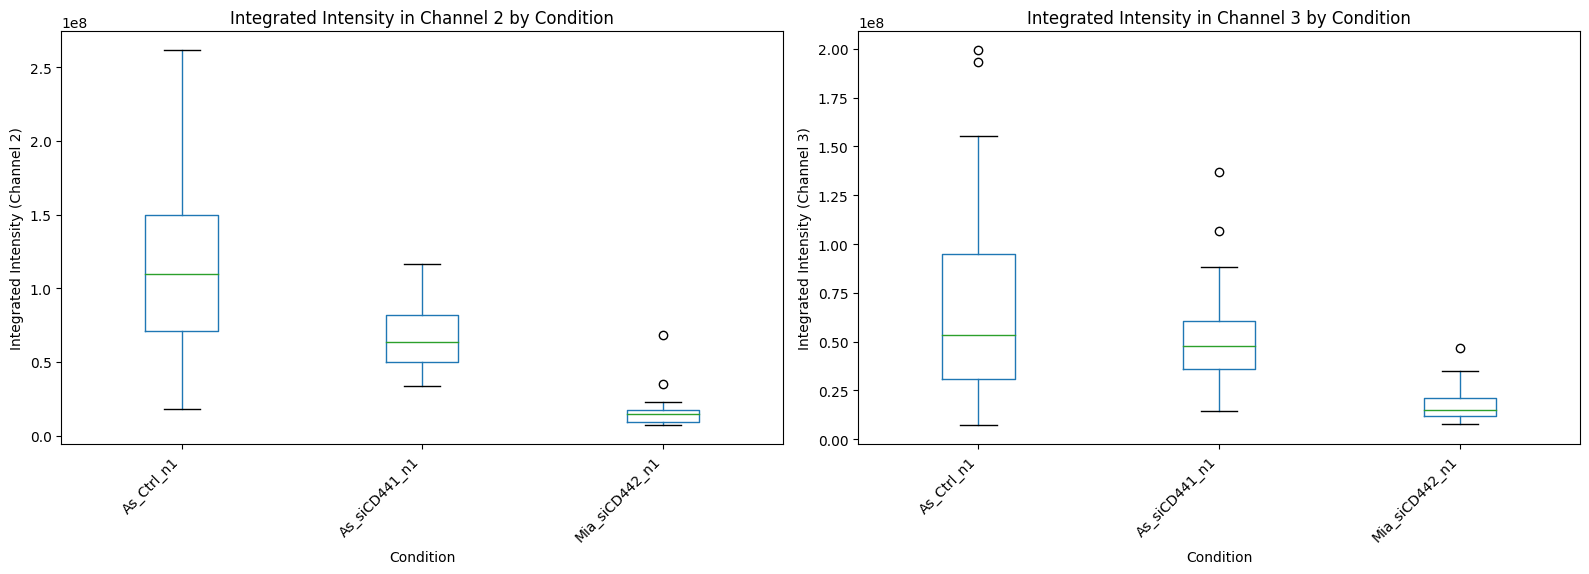

In [4]:
#@markdown # Visualize data (optional)
# Step 5: Visualize the Differences Between Conditions

import matplotlib.pyplot as plt

# Initialize empty DataFrame to hold all data
all_data = pd.DataFrame()

# Read all pooled CSV files in the csv_output_dir
for csv_file in os.listdir(csv_output_dir):
    if csv_file.endswith('.csv'):
        csv_file_path = os.path.join(csv_output_dir, csv_file)
        df = pd.read_csv(csv_file_path)
        # Extract base_name from the csv file name
        base_name = csv_file.replace('_intensities.csv', '')
        df['condition'] = base_name  # Add a 'condition' column based on base_name
        all_data = pd.concat([all_data, df], ignore_index=True)

# Ensure that 'condition' is treated as a categorical variable
all_data['condition'] = all_data['condition'].astype('category')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Integrated Intensity in Channel 2 for Each Condition
all_data.boxplot(column='integrated_intensity_channel_2', by='condition', grid=False, ax=axes[0])
axes[0].set_title('Integrated Intensity in Channel 2 by Condition')
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Integrated Intensity (Channel 2)')

# Plot 2: Integrated Intensity in Channel 3 for Each Condition
all_data.boxplot(column='integrated_intensity_channel_3', by='condition', grid=False, ax=axes[1])
axes[1].set_title('Integrated Intensity in Channel 3 by Condition')
axes[1].set_xlabel('Condition')
axes[1].set_ylabel('Integrated Intensity (Channel 3)')

# Optionally, rotate x-axis labels if needed
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout and remove the default suptitle
plt.suptitle('')  # Suppress the default suptitle
plt.tight_layout()
plt.show()